<a href="https://colab.research.google.com/github/Nidhi-Mantri/Melanoma-Detection/blob/main/Assignment_CNN_Skin_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
for images, labels in train_ds.take(1):
    print("Images are -", len(images))
    print("Labels are -", len(labels))

Images are - 32
Labels are - 32


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

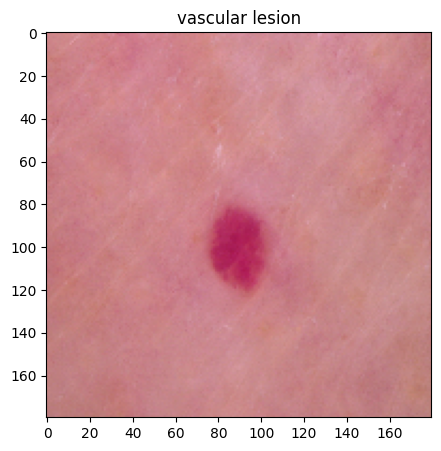

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# figure size
plt.figure(figsize=(5, 5 ))
# let's plot one image from 1st batch
for images, labels in train_ds.take(1):
    plt.imshow(images[1].numpy().astype("uint8"))
    plt.title(class_names[labels[1]])
    break
    plt.axis("off")

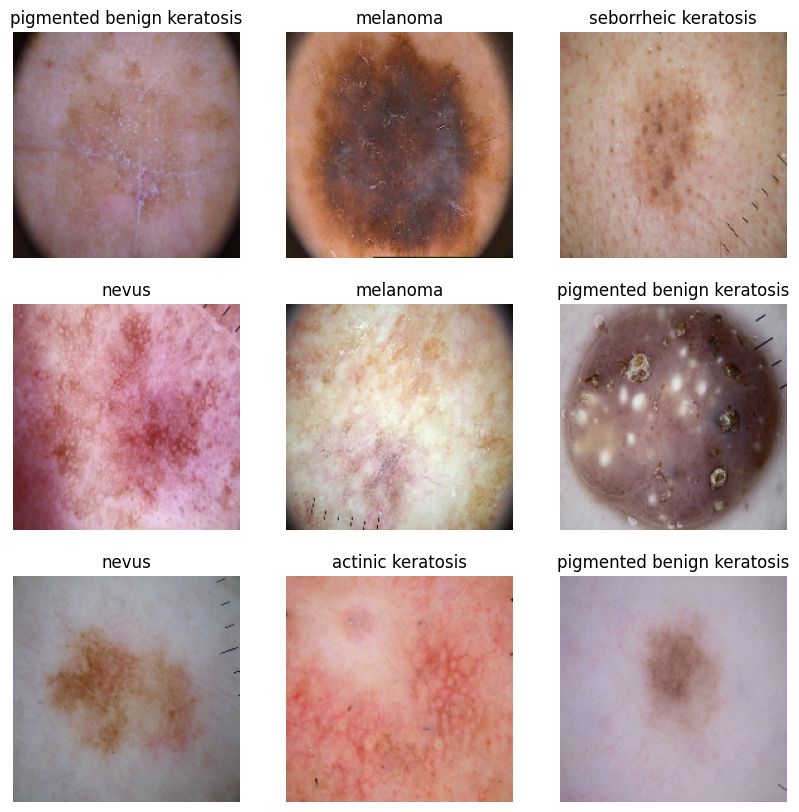

In [ ]:
# let's plot 9 images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
num_classes = 9

# a sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
    # rescaling
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # 2D convulation layer
    layers.Conv2D(16, 3, padding="same", activation="relu"),

    # maxpooling layer - we extract tiles of specified size by sliding over the feature map from above layer, now
    # let's downsamples the input along its spatial dimensions (height and width) using max pool layer
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    # Flattening layer - convert into 1D feature vector
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(128, activation="relu"),


    # again a dense layers but with "num_classes" neurons
    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 257s 3s/step - loss: 1.9272 - accuracy: 0.3170 - val_loss: 1.6357 - val_accuracy: 0.4653
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5323 - accuracy: 0.4609 - val_loss: 1.4445 - val_accuracy: 0.5213
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3824 - accuracy: 0.5257 - val_loss: 1.4114 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2769 - accuracy: 0.5525 - val_loss: 1.4367 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2162 - accuracy: 0.5748 - val_loss: 1.4154 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.0826 - accuracy: 0.6183 - val_loss: 1.4512 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.0605 - accuracy: 0.6306 - val_loss: 1.5579 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualizing training results

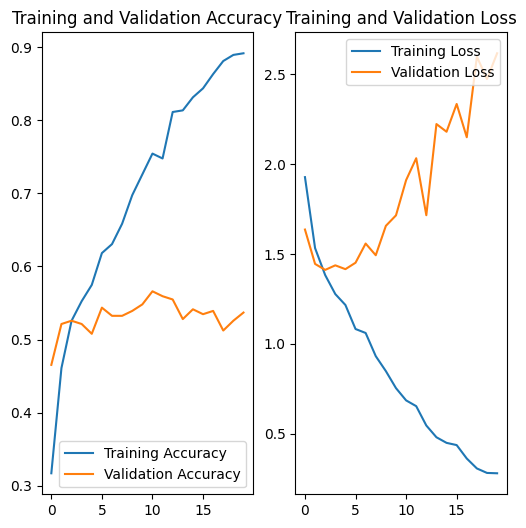

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### The above results indicates that our model is overfitting, it is doing good on training data but worse on validation data. we can see that accuracy is continuously increasing and loss is decreasing for train data but for validation data, accuracy is around 50% but loss is continously increasing..

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                     input_shape=(img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomTranslation(1, .5, fill_mode="reflect", interpolation='bilinear', seed=None, fill_value=0.0),
        layers.experimental.preprocessing.RandomCrop(img_height, img_width),
    ]
)

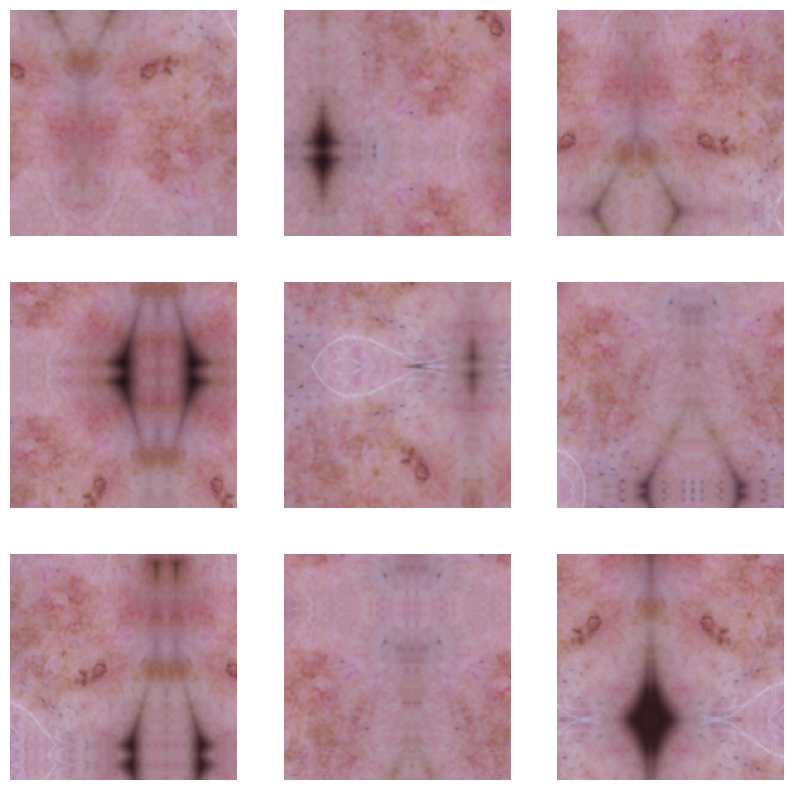

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here
num_classes = 9

# a sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
    data_augmentation,  ## augmentation part
    # rescaling
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # 2D convulation layer
    layers.Conv2D(16, 3, padding="same", activation="relu"),

    # maxpooling layer - we extract tiles of specified size by sliding over the feature map from above layer, now
    # let's downsamples the input along its spatial dimensions (height and width) using max pool layer
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    # Flattening layer - convert into 1D feature vector
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(128, activation="relu"),


    # again a dense layers but with "num_classes" neurons
    layers.Dense(num_classes)
])


### Compiling the model

In [ ]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 37ms/step - loss: 2.0185 - accuracy: 0.2266 - val_loss: 1.8905 - val_accuracy: 0.3020
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.8491 - accuracy: 0.3047 - val_loss: 1.7702 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6902 - accuracy: 0.3560 - val_loss: 1.6573 - val_accuracy: 0.3400
Epoch 4/20
56/56 [==============================] - 2s 33ms/step - loss: 1.6830 - accuracy: 0.3638 - val_loss: 1.7097 - val_accuracy: 0.3736
Epoch 5/20
56/56 [==============================] - 2s 36ms/step - loss: 1.6346 - accuracy: 0.3878 - val_loss: 1.5974 - val_accuracy: 0.4318
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5961 - accuracy: 0.4007 - val_loss: 1.5219 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5515 - accuracy: 0.4208 - val_loss: 1.6064 - val_accuracy: 0.4049
Epoch 8/20
56

### Visualizing the results

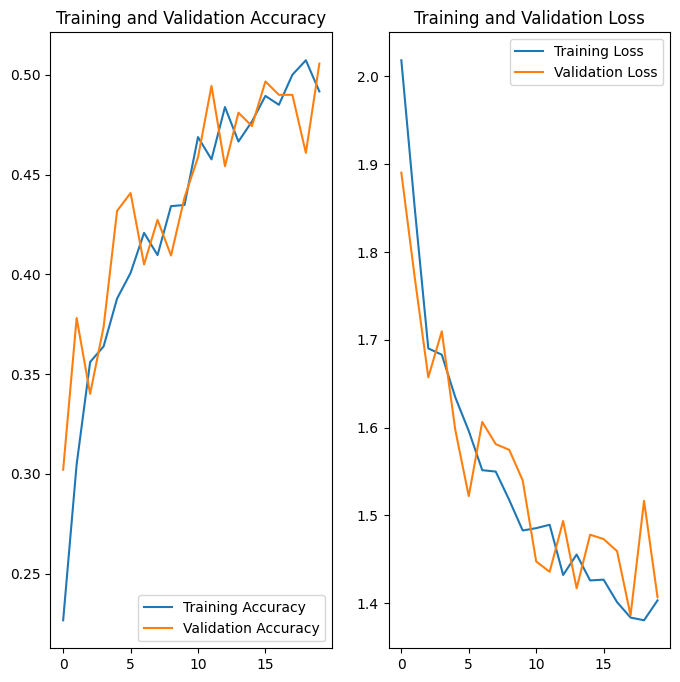

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Yes, this time model doesn't overfit, it is doing continuously better with small fluctuations in between. Accuracy on train and validation data is increasing and loss is decreasing..

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(path_list), len(lesion_list))

2239 2239


In [ ]:
dict_df = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dict_df.items()), columns=["Path", "Label"])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,nevus
...,...,...
2234,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,dermatofibroma
2235,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,dermatofibroma
2236,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,dermatofibroma
2237,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,dermatofibroma


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Class - nevus , No. of items - 357 , Percent of Total - 15.94
Class - melanoma , No. of items - 438 , Percent of Total - 19.56
Class - basal cell carcinoma , No. of items - 376 , Percent of Total - 16.79
Class - pigmented benign keratosis , No. of items - 462 , Percent of Total - 20.63
Class - vascular lesion , No. of items - 139 , Percent of Total - 6.21
Class - squamous cell carcinoma , No. of items - 181 , Percent of Total - 8.08
Class - actinic keratosis , No. of items - 114 , Percent of Total - 5.09
Class - seborrheic keratosis , No. of items - 77 , Percent of Total - 3.44
Class - dermatofibroma , No. of items - 95 , Percent of Total - 4.24


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'nevus'),
  Text(1, 0, 'melanoma'),
  Text(2, 0, 'basal cell carcinoma'),
  Text(3, 0, 'pigmented benign keratosis'),
  Text(4, 0, 'vascular lesion'),
  Text(5, 0, 'squamous cell carcinoma'),
  Text(6, 0, 'actinic keratosis'),
  Text(7, 0, 'seborrheic keratosis'),
  Text(8, 0, 'dermatofibroma')])

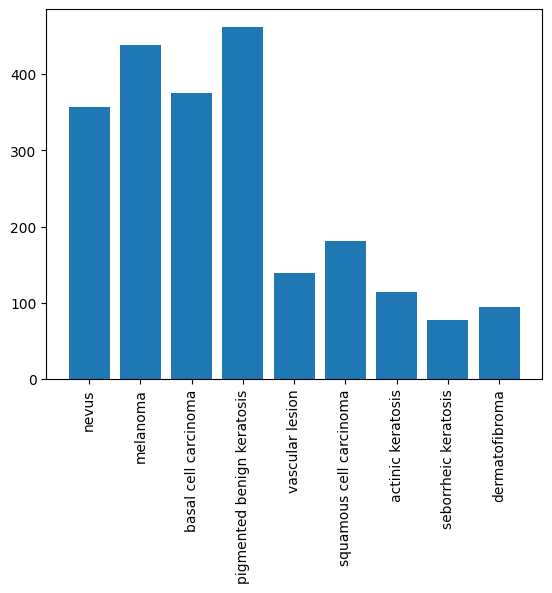

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
X, y = original_df['Path'], original_df['Label']

# summarize
counter = Counter(y)
for key, value in counter.items():
    per = value / len(y) * 100
    print("Class -", key, ", No. of items -", value, ", Percent of Total -", round(per,2))
# print(counter)
plt.bar(counter.keys(), counter.values())
plt.xticks(rotation=90)

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA07823BAC0>: 100%|██████████| 500/500 [00:19<00:00, 25.34 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA078287910>: 100%|██████████| 500/500 [00:17<00:00, 28.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BA0782A6440>: 100%|██████████| 500/500 [00:18<00:00, 26.78 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BA08003BC40>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7BA0805FEB30>: 100%|██████████| 500/500 [01:18<00:00,  6.36 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA0784E7730>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BA0787E4160>: 100%|██████████| 500/500 [00:39<00:00, 12.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA078734910>: 100%|██████████| 500/500 [00:17<00:00, 28.29 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA0802A8E50>: 100%|██████████| 500/500 [00:17<00:00, 28.73 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000341.jpg_aa2beead-2404-414c-97d0-e663a219246f.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000025.jpg_87708a34-39c5-4ba9-a0f1-b3116ca66ecb.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000494.jpg_bfcccb00-9604-4e35-997d-cbf16491dcff.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000079.jpg_77f5d5a7-a1ba-4d82-90cc-a53ada05e340.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000472.jpg_614c3881-3b36-4ebd-9c6a-7eb2d57d6281.jpg',
 '/content/gdri

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-58-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [4]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [5]:
data_dir_train=pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [7]:
## Your code goes here
num_classes = 9

# a sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
    #data_augmentation,  ## augmentation part
    # rescaling
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # 2D convulation layer
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    # maxpooling layer - we extract tiles of specified size by sliding over the feature map from above layer, now
    # let's downsamples the input along its spatial dimensions (height and width) using max pool layer
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    # Flattening layer - convert into 1D feature vector
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(256, activation="relu"),

    # again a dense layers but with "num_classes" neurons
    layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [8]:
## your code goes here
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 843s 5s/step - loss: 3.4919 - accuracy: 0.2891 - val_loss: 68.0859 - val_accuracy: 0.0898
Epoch 2/30
169/169 [==============================] - 667s 4s/step - loss: 1.6805 - accuracy: 0.3687 - val_loss: 20.2538 - val_accuracy: 0.1863
Epoch 3/30
169/169 [==============================] - 675s 4s/step - loss: 1.4773 - accuracy: 0.4445 - val_loss: 3.2630 - val_accuracy: 0.3460
Epoch 4/30
169/169 [==============================] - 626s 4s/step - loss: 1.3335 - accuracy: 0.4839 - val_loss: 1.5676 - val_accuracy: 0.4202
Epoch 5/30
169/169 [==============================] - 612s 4s/step - loss: 1.2072 - accuracy: 0.5171 - val_loss: 2.4471 - val_accuracy: 0.3608
Epoch 6/30
169/169 [==============================] - 615s 4s/step - loss: 1.1049 - accuracy: 0.5629 - val_loss: 1.6667 - val_accuracy: 0.4343
Epoch 7/30
169/169 [==============================] - 667s 4s/step - loss: 1.0423 - accuracy: 0.5992 - val_loss: 2.7871 - val_accuracy: 0.33

#### **Todo:**  Visualize the model results

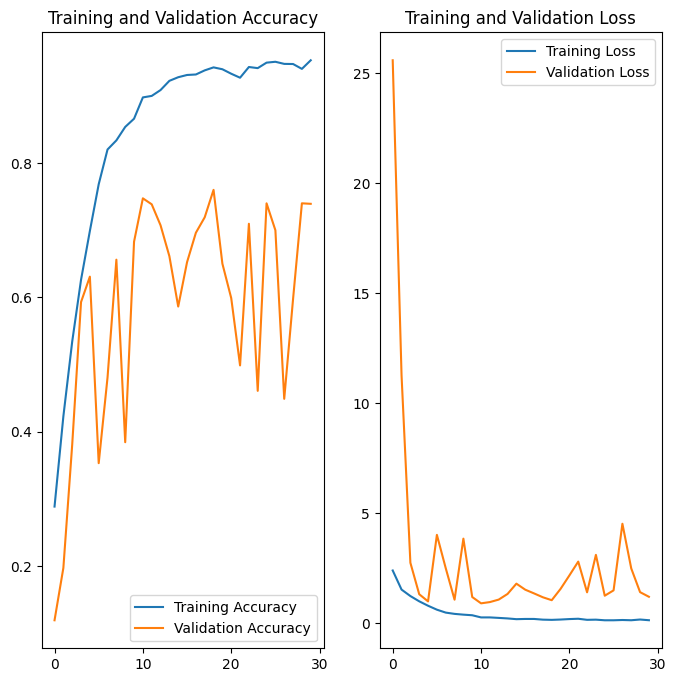

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Yes class rebalance helped, but from graph we can see that validation accuracy is stucked around 60%. At this point, we can try with various combination of layers, dropouts, batch normalization, etc.

#### Also, if we compare previous graph (with data augmentation) with this one, then we can see that this time there are no fluctuations till 50% but in previous graph, in 50 epochs it reached till 50% of accuracy that too with a lot of fluctuations. So, overall our model performance has improved, and it's good in sense that we will be able to learn a lot more about less frequent data now.